In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
import matplotlib.pyplot as plt
import numpy as np 
from qiskit import transpile
from qiskit_aer import AerSimulator 
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info.states import partial_trace
import pandas as pd 
import scipy.linalg as la

In [3]:
def rand_real_circ(L, p, timesteps, flag=0):

    if flag == 1:
        qc = QuantumCircuit(L,L)
    
    #Randomly Select L*p qubits 
    meas = int(np.floor(L*p))
    
    for j in range(0, timesteps):

        s = np.random.choice([0,1,2], 1)
        qubits = [i for  i in range(0,L)]
        
        if s == 0:
            #Single Qubit Gates
            for i in range(0,L):
                v = np.random.randint(0,10, size=1)
                if v <= 5:
                    qc.h(i)
                elif v > 5:
                    qc.s(i)
            #Perform Random Measurement
            a = np.random.choice(qubits, size=meas)
            for i in a:
                qc.measure(i, i)
                
        elif s == 1:
            #Control-Target Gates: 
            for i in range(0, L):
                if i == L-1:
                    break
                else:
                    qc.cx(i,i+1)
                    
                #Perform Random Measurement
                a = np.random.choice(qubits, size=meas)
                for i in a:
                    qc.measure(i, i)

            
        elif s == 2:
            #Target-Control Gates: 
            for i in range(0, L):
                if i == L-1:
                    break
                else:
                    qc.cx(i+1,i)   

                #Perform Random Measurement
                a = np.random.choice(qubits, size=meas)
                for i in a:
                    qc.measure(i, i)
        
    return qc

def rand_sim_circ(L, timesteps, flag = 0):

    if flag == 1:
        qc = QuantumCircuit(L)

    for j in range(0, timesteps):
        
        s = np.random.choice([0,1,2], 1)
        
        if s == 0:
            #Single Qubit Gates
            for i in range(0,L):
                v = np.random.choice([0,1], 1)
                if v == 0:
                    qc.h(i)
                elif v == 1:
                    qc.s(i)
                    
        elif s == 1:
            #Control-Target Gates: 
            for i in range(0, L):
                if i == L-1:
                    break
            else:
                qc.cx(i,i+1)
                
        elif s == 2:
            #Target-Control Gates: 
            for i in range(0, L):
                if i == L-1:
                    break
                else:
                    qc.cx(i+1,i)
        
    return qc


def diagonalize(rho):
    u, D = la.eig(rho)
    return D 

def renyi(diags, n):
    assert n != None, "Please supply a value for n."
    assert n > 0, "Renyi Entropy is only analytical for n > 0."    
    
    if n != 1: 
        a = 1/(1-n) 
        b = np.trace(diags)**n
        return a * np.log2(b)
    elif n == 1:  
        return -np.sum(diags * np.log2(diags))

def find_subspaces(L):
    subspaces = []
    for i in range(0, L):
        for j in range(i,L): 
            a = list(range(i , j+1))
            subspaces.append(a)  
    subspaces.sort(key=len)
    subspaces = subspaces[0:-1]
    return subspaces

In [4]:
def rand_real_circ2(L, p, timesteps):
    
    qc = QuantumCircuit(L,L)
    
    #Randomly Select L*p qubits 
    meas = int(np.floor(L*p))
    qubits = [i for  i in range(0,L)]
    
    for j in range(0, timesteps):

                   
        #Single Qubit Gates
        for i in range(0,L):
            if i % 2 == 0:
                qc.h(i)
            elif i % 2 == 1:
                qc.s(i)
        
        #Perform Random Measurement
        a = np.random.choice(qubits, size=meas)
        for i in a:
            qc.measure(i, i)        

        #Control-Target Gates: 
        for i in range(0, L):
            if i == L-1:
                break
            else:
                qc.cx(i,i+1)
        
        #Perform Random Measurement
        a = np.random.choice(qubits, size=meas)
        for i in a:
            qc.measure(i, i)        
        

        #Target-Control Gates: 
        for i in range(0, L):
            if i == L-1:
                break
            else:
                qc.cx(i+1,i)   

        #Perform Random Measurement
        a = np.random.choice(qubits, size=meas)
        for i in a:
            qc.measure(i, i)
            
        #Single Qubit Gates
        for i in range(0,L):
            if i % 2 == 0:
                qc.h(i)
            elif i % 2 == 1:
                qc.s(i)
        
        #Perform Random Measurement
        a = np.random.choice(qubits, size=meas)
        for i in a:
            qc.measure(i, i)

    return qc

In [9]:
#initialize circuit parameters
L = 3
depth = 5
p = [1/3, 2/3] 
subspaces = find_subspaces(L)

#Construct backend once
backend = AerSimulator(method='density_matrix')

runs = {}
for measurement_rate in p:
    #Contstruct Random Circuit of Fixed Length 
    qc = rand_real_circ2(L, measurement_rate, depth)

    #Save Density Matrix and run simulator
    qc.save_density_matrix()
    comp_qc = transpile(qc, backend)
    result = backend.run(comp_qc, shots=100).result()
    rho = result.data()

    #Perform Diagonilzation and Renyi Entropy Calculations
    D = diagonalize(rho['density_matrix']) 

    sub_ents = {}
    for item in subspaces:
        reduc_rho = partial_trace(rho['density_matrix'], list(item))
        D = diagonalize(reduc_rho)
        sub_ents[f"{item}"] = [len(item), renyi(D, 2)]

    #Save current run to dictionary out of the loop
    runs[f"{measurement_rate}"] = sub_ents    

In [10]:
new_ent = {}
for key in runs.keys():
    a = runs[key]
    b = {}
    for i in range(0,L):
        running_ave = 0
        count = 0
        for pair in a.values():
            if pair[0] == i:
                count += 1
                if pair[1] < 50:
                    running_ave += pair[1]
    
        if count != 0:
            running_ave = running_ave/count
        if running_ave != 0: 
            b[i] = running_ave
    new_ent[key] = b

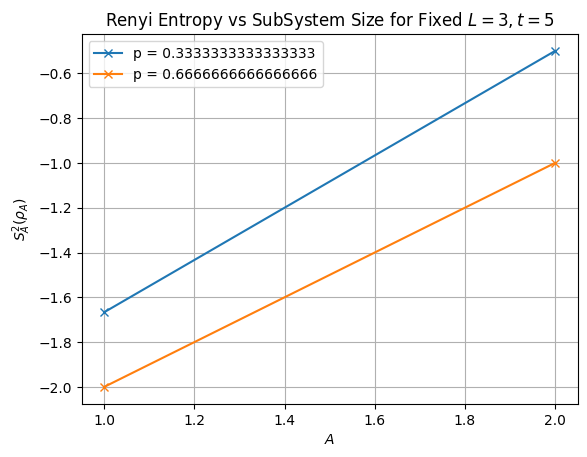

In [11]:
plt.figure()
plt.title(f'Renyi Entropy vs SubSystem Size for Fixed $L = {L}, t={depth}$')
plt.xlabel(r'$A$')
plt.ylabel(r'$S_{A}^2 (\rho_{A})$')
plt.grid()
for key in new_ent.keys():
    run = new_ent[key]
    x , y = zip(*run.items())
    plt.plot(x, y, 'x-', label=f"p = {key}")
plt.legend()
#plt.savefig(f'./images/L_{L}_cir_3_t_{depth}.png')
plt.show()

In [14]:
new_ent

{'0.3333333333333333': {1: np.complex128(-1.6666666666666679+0j),
  2: np.complex128(-0.5000000000000003+0j)},
 '0.6666666666666666': {1: np.complex128(-2.0000000000000013+0j),
  2: np.complex128(-1+0j)}}

In [18]:
df = pd.DataFrame.from_dict(new_ent, orient='index')
df.to_csv('out.csv')